In [1]:
from huggingface_hub import login
from esm.models.esm3 import ESM3
from esm.sdk.api import ESM3InferenceClient, ESMProtein, GenerationConfig, ESMProteinTensor
from protein_interpretability.extractor import ESM3ActivationExtractor
from dotenv import load_dotenv
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from protein_interpretability.viz import plot_all_layers_sorted_paged

In [2]:
stable = [
"MSKGEELFTTVVPILVELDXDVNGHKFSVSGEGEGDATSGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDLGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMYQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"
]

unstable = [
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYDKKTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK",
"MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"
]

In [3]:
from esm.sdk.api import ESMProtein, GenerationConfig


model: ESM3InferenceClient = ESM3.from_pretrained("esm3-open").to("cuda") # or "cpu"

# Wrap each as ESMProtein (sequence-only; structure/other tracks optional)
inputs = [ESMProtein(sequence=s) for s in stable]
configs = [GenerationConfig(track="sequence", num_steps=2, temperature=0.7)] * len(stable)

# Batch generate (model from ESM3.from_pretrained(...))
outputs = model.batch_generate(inputs, configs)
# outputs: list[ESMProtein | ESMProteinError]

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


In [4]:
extractor = ESM3ActivationExtractor(
    model,
    sites=None,              # all: encoder, transformer_out, transformer_embed, output_heads_in
    layers=None,             # all transformer blocks
    layer_sites=["block", "attn", "geom_attn", "ffn"],  # default is only ["block"]
    detach=True,
)

with extractor.recording():
    outputs = model.batch_generate(inputs, configs)


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.89it/s]


In [5]:
# so now we can acces to the batch activations of shape (Bathced, node, features) for each site for each step 
extractor.get_step(0)["layer_0_block"]

tensor([[[ 0.6719, -0.5469,  0.0093,  ...,  1.5469, -0.3008,  0.5898],
         [-0.0317,  0.3945, -0.0547,  ...,  1.2500,  0.7383,  0.4180],
         [ 0.2344,  0.0928, -0.6367,  ...,  1.2344, -0.0820,  0.0605],
         ...,
         [ 0.1318,  0.5312,  0.0664,  ...,  1.5156, -0.2656,  0.4043],
         [ 0.5391,  0.4375, -0.0771,  ...,  1.3281,  0.4180,  0.2930],
         [ 0.3086, -0.0410, -0.1836,  ...,  1.4922, -0.3086,  0.3047]],

        [[ 0.6953, -0.5547,  0.0127,  ...,  1.5703, -0.3164,  0.5781],
         [-0.0020,  0.3809, -0.0547,  ...,  1.2344,  0.7188,  0.3926],
         [ 0.2598,  0.0801, -0.6406,  ...,  1.2109, -0.0991,  0.0283],
         ...,
         [ 0.1406,  0.5273,  0.0615,  ...,  1.5078, -0.2754,  0.4023],
         [ 0.5547,  0.4297, -0.0771,  ...,  1.3125,  0.4082,  0.2910],
         [ 0.3203, -0.0486, -0.1865,  ...,  1.4531, -0.3203,  0.2910]],

        [[ 0.6875, -0.5547,  0.0024,  ...,  1.5547, -0.3066,  0.5703],
         [-0.0029,  0.3789, -0.0581,  ...,  1

In [6]:
import importlib
import protein_interpretability.viz  # or wherever the package lives
importlib.reload(protein_interpretability.viz)
from protein_interpretability.viz import plot_all_layers_sorted_paged  # re-bind name

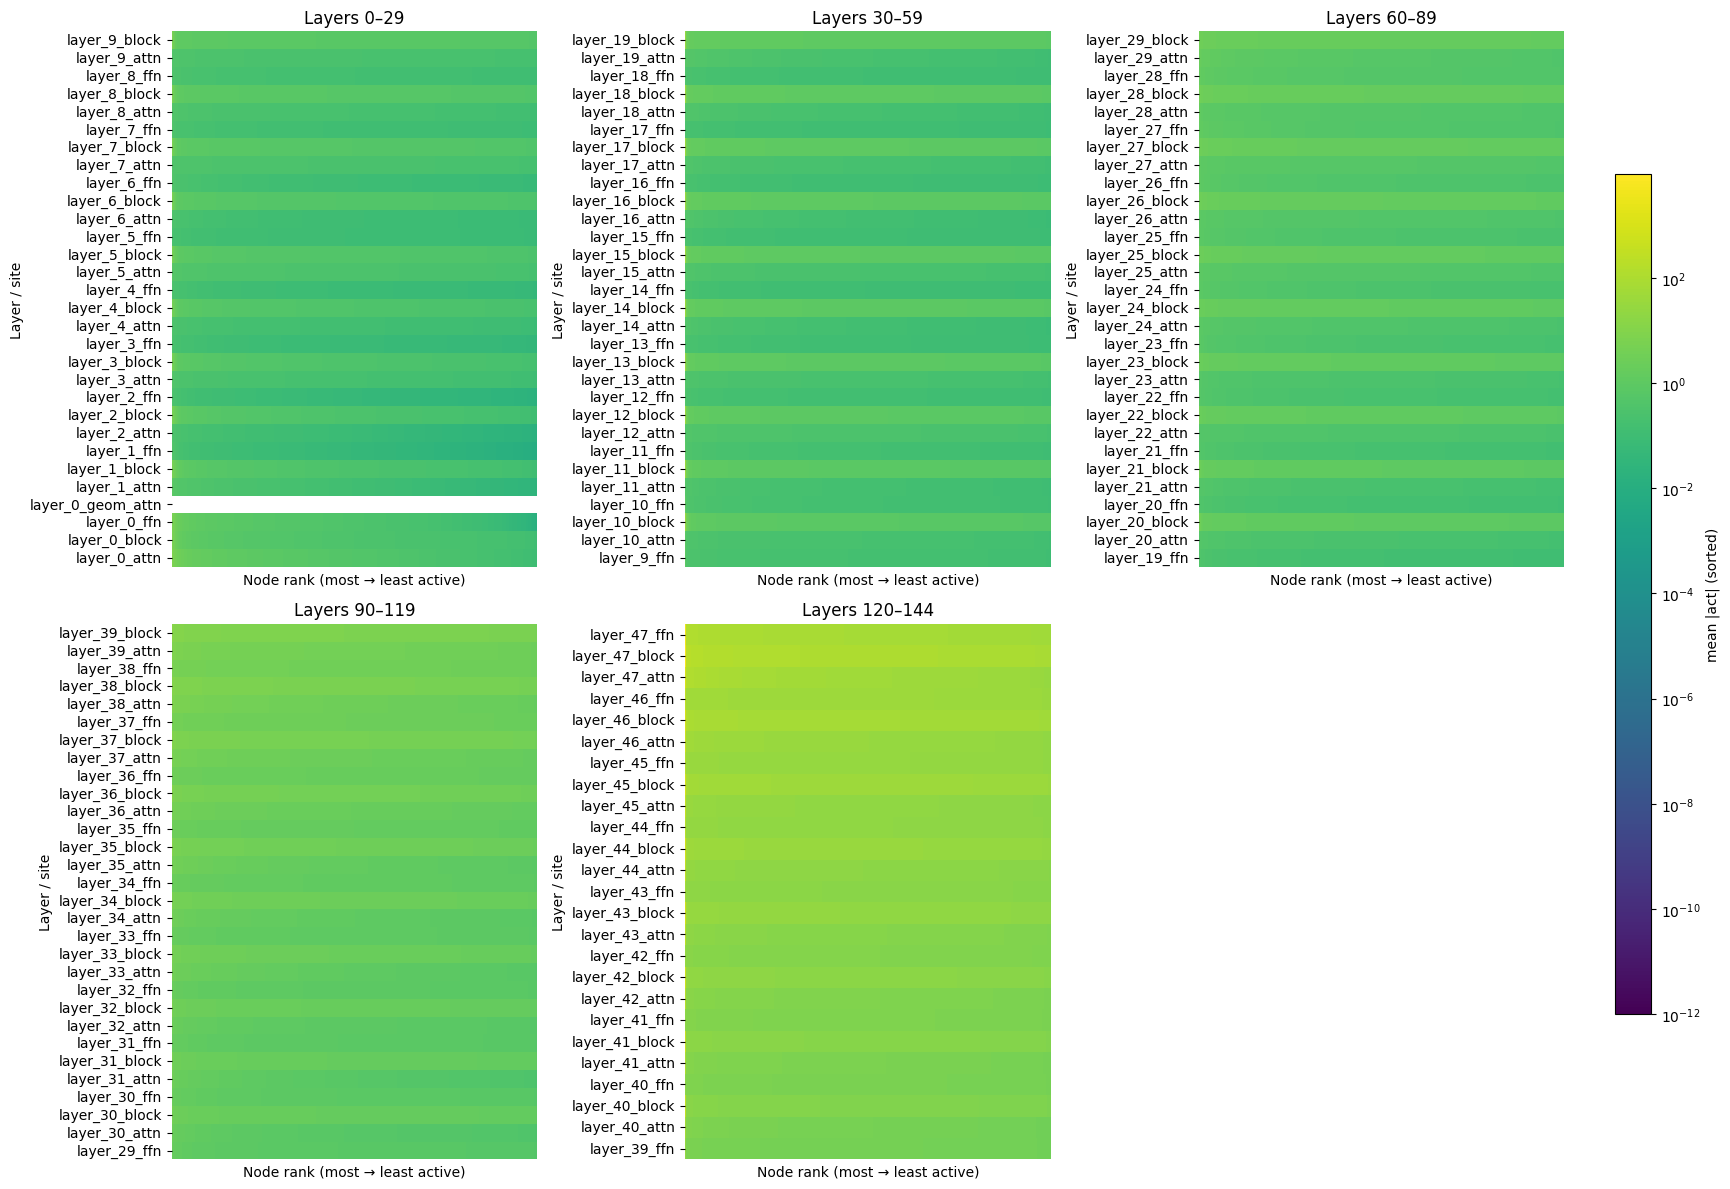

In [7]:
fig, ax = plot_all_layers_sorted_paged(extractor.get_step(0))

## Compare both Activations: 

In [10]:
means_layer_0 = extractor.get_mean_activations_per_layer(step=0, reduce_batch=False)


In [27]:
def reduce_layer_tensor(t: torch.Tensor, reducer: str = "rms") -> torch.Tensor:
    """
    Reduce (B, D) -> (B,) or pass through if already (B,).
    """
    if t.dim() == 1:
        return t

    if reducer == "mean":
        return t.mean(dim=-1)
    if reducer == "absmean":
        return t.abs().mean(dim=-1)
    if reducer == "rms":
        return torch.sqrt((t * t).mean(dim=-1) + 1e-12)
    if reducer == "norm":
        return t.norm(p=2, dim=-1)

    raise ValueError(f"Unknown reducer: {reducer}")
    

import re
import numpy as np
import matplotlib.pyplot as plt
import torch

_LAYER_INDEX_RE = re.compile(r"layer_(\d+)")

def _layer_idx(name: str) -> int:
    m = _LAYER_INDEX_RE.search(name)
    return int(m.group(1)) if m else -1


def plot_layer_scalars(
    layer_dict: dict[str, torch.Tensor],
    *,
    reducer: str = "rms",
    groups: np.ndarray | None = None,   # optional group labels (B,)
    group_colors: dict | None = None,
    alpha: float = 0.6,
):
    """
    Plot layer-wise scalar summary per batch item.

    layer_dict: dict[layer_name] -> tensor (B,) or (B, D)
    groups: optional (B,) array for coloring
    """

    keys = sorted(layer_dict.keys(), key=_layer_idx)
    keys = [k for k in keys if _layer_idx(k) >= 0]

    arr = []
    for k in keys:
        t = layer_dict[k]
        t = t.detach().cpu().float()
        t = reduce_layer_tensor(t, reducer=reducer)
        arr.append(t.numpy())

    arr = np.stack(arr, axis=0)  # (n_layers, B)

    x = np.arange(arr.shape[0])
    B = arr.shape[1]

    fig, ax = plt.subplots()

    for b in range(B):
        if groups is not None:
            g = groups[b]
            color = group_colors[g] if group_colors else None
        else:
            color = None

        ax.plot(x, arr[:, b], alpha=alpha, color=color)

    ax.set_xlabel("Layer index")
    ax.set_ylabel(reducer)
    ax.set_title(f"Layer-wise {reducer}")
    fig.tight_layout()

    return fig, ax

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Layer-wise rms'}, xlabel='Layer index', ylabel='rms'>)

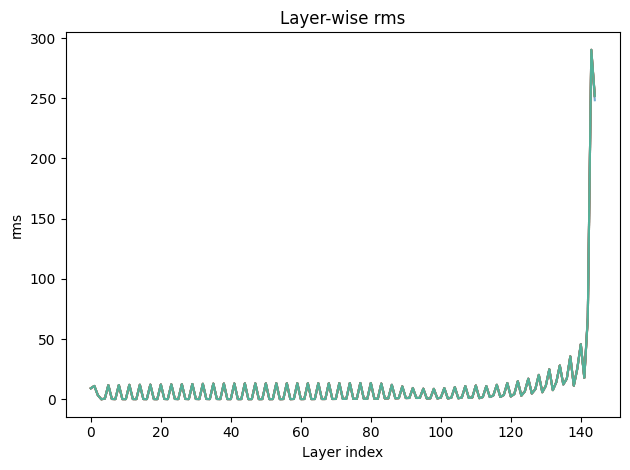

In [28]:
plot_layer_scalars(means_layer_0,  reducer="rms")

In [29]:

def cosine_similarity_matrix(x: torch.Tensor) -> np.ndarray:
    """
    x: (B, dim). Returns (B, B) pairwise cosine similarity matrix.
    """
    x = x.detach().float()
    x_norm = x / (x.norm(p=2, dim=-1, keepdim=True).clamp(min=1e-8))
    out = x_norm @ x_norm.T
    return out.cpu().numpy()


def plot_cosine_similarity_matrix(
    matrix: np.ndarray,
    *,
    title: str | None = None,
    ax: plt.Axes | None = None,
    vmin: float = -1.0,
    vmax: float = 1.0,
):
    """
    matrix: (B, B) cosine similarity. Plots heatmap.
    Returns fig, ax (ax is the one used).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    else:
        fig = ax.figure
    sns.heatmap(
        matrix,
        ax=ax,
        cmap="RdBu_r",
        center=0,
        vmin=vmin,
        vmax=vmax,
        square=True,
    )
    ax.set_xlabel("Batch index")
    ax.set_ylabel("Batch index")
    if title is not None:
        ax.set_title(title)
    return fig, ax

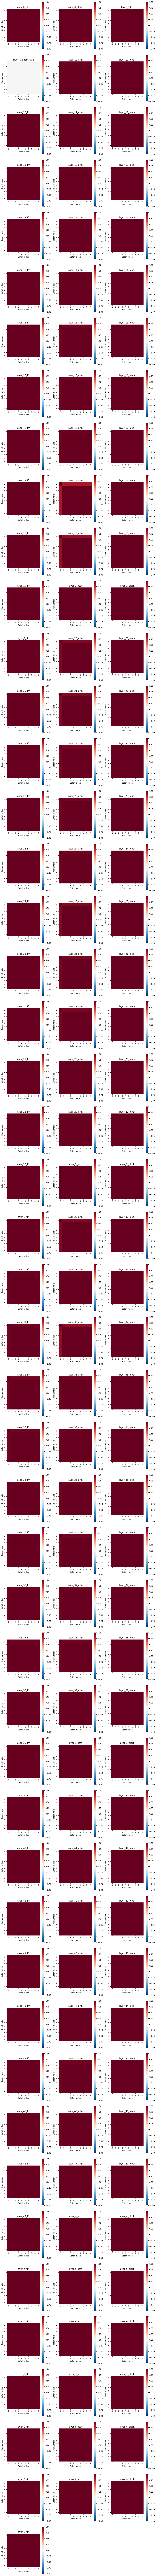

In [32]:
n = len(means_layer_0)
ncols = 3
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)
for ax, (layer_name, t) in zip(axes.ravel(), means_layer_0.items()):
    mat = cosine_similarity_matrix(t)
    plot_cosine_similarity_matrix(mat, title=layer_name, ax=ax)
for ax in axes.ravel()[n:]:
    ax.axis("off")
fig.tight_layout()